### This code is to implement bi-directional sweeps in the HD attractor network

In [1]:
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
from network import HD_cell

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/zilong/anaconda3/envs/anticipative_track/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plot functions

In [38]:
def plot_HDsweep(ax, t, Head_direction, bump_center, max_bump_activity, bump_activity):
    
    labelsize=10
    ticksize=8
    # imshow and smooth
    ax.imshow(bump_activity.T*100, aspect='auto', extent=[t[0], t[-1], -bm.pi, bm.pi], cmap='inferno', origin='lower')
    
    #plot the head direction as a line
    ax.plot(t, Head_direction, color='white', lw=2)
    
    #add colorbar
    cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Activity (Hz)', fontsize=ticksize)
    #set ticks
    cbar.ax.set_yticks([0, int(np.max(bump_activity)*100/10)*10])

    cbar.ax.tick_params(labelsize=ticksize)
    
    #xticks
    ax.set_xticks([t[0], t[-1]])
    ax.set_xticklabels([t[0]-t[0], (t[-1]-t[0])/1000])
    #yticks
    ax.set_yticks([-bm.pi, 0, bm.pi])
    ax.set_yticklabels([r'$0\degree$', r'$180\degree$', r'$360\degree$'])
    
    #label
    ax.set_xlabel('Time (s)', fontsize=labelsize)
    ax.set_ylabel('Direction', fontsize=labelsize)
    #ticksize
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def plot_HDsweepdistribution(ax, offset):

    ax.hist(offset, bins=20, color='#38c7ff')
    # Set zero to be at the top
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_theta_offset(np.pi / 2.0)  # Zero at the top
    #yticks off
    ax.set_yticks([])
    #xticks as 0, 90, 180, 270
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    #ticklabels as front, right, left
    ax.set_xticklabels(['Front', 'Right', '', 'Left'], fontsize=8)
    
    return ax

## Section 1: define the network

In [2]:
bm.set_dt(1.)

def run_HDNet(i, Head_direction):  # 20 x size
    HD_net = HD_cell(num=100, 
                    noise_stre=0.6, 
                    tau=10., tau_v=100., 
                    k=1., mbar=20, a=0.4, A=3., J0=4., 
                    z_min=-bm.pi, z_max=bm.pi)

    T_theta = 100 #ms
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    #calculate TheataModulator at time step i
    ThetaModulator_HD = 1+0.28*bm.cos(theta_phase*2*bm.pi)
    HD_net.step_run(i, Head_direction, ThetaModulator_HD)
    bump_center = HD_net.center
    bump_activity = HD_net.r
    return bump_center, bump_activity

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Section 2: simulate the HD network when head direction is fixed

100%|██████████| 4000/4000 [00:00<00:00, 17709.46it/s]


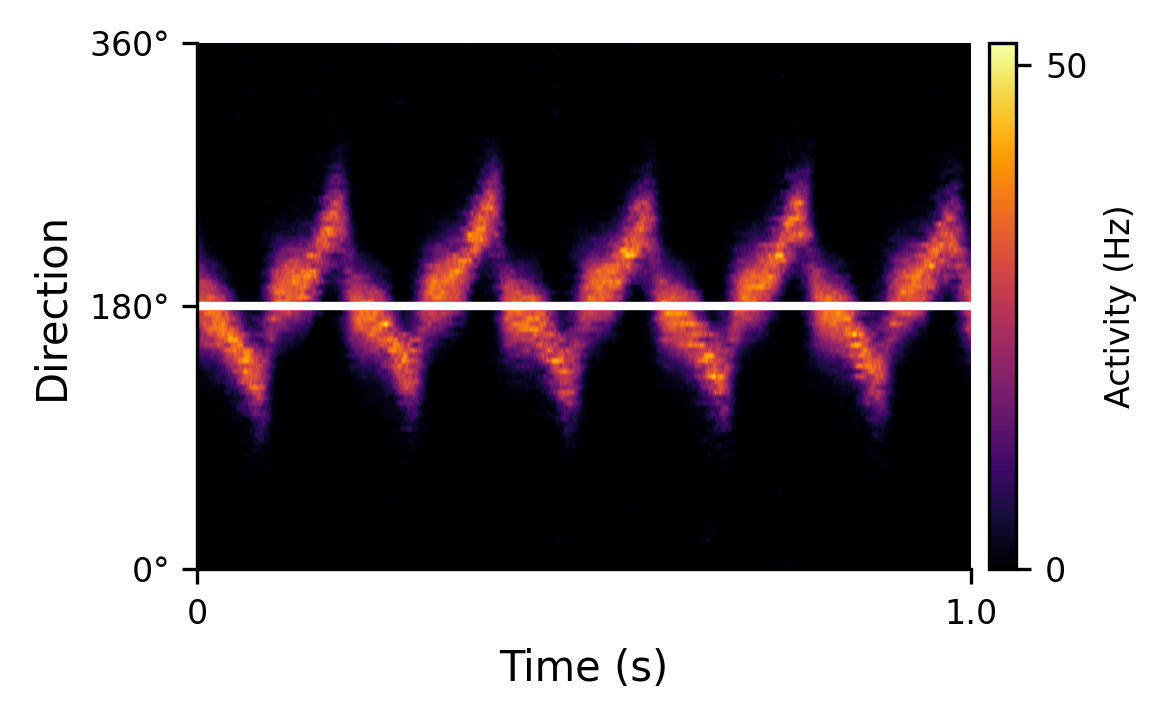

In [46]:
numT = 4000 #ms

time_steps = np.arange(numT)
Head_direction = 0*bm.pi*bm.ones(numT) #fixed head direction, mimicking the animal running in a straight line
bump_center, bump_activity = bm.for_loop(run_HDNet, (time_steps, Head_direction), progress_bar=True)
max_bump_activity = np.max(bump_activity, axis=1)

start = 1000
end = 2000+1


#polor plot in axs[1]
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=300)
ax = plot_HDsweep(ax, 
                  time_steps[start:end], 
                  Head_direction[start:end], 
                  bump_center[start:end], 
                  max_bump_activity[start:end],
                  bump_activity[start:end])
plt.tight_layout()
plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/HD_sweep_static.pdf', dpi=300)

## Section 3: simulate the network when head direction is rotating at a constant speed

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:00<00:00, 17790.36it/s]


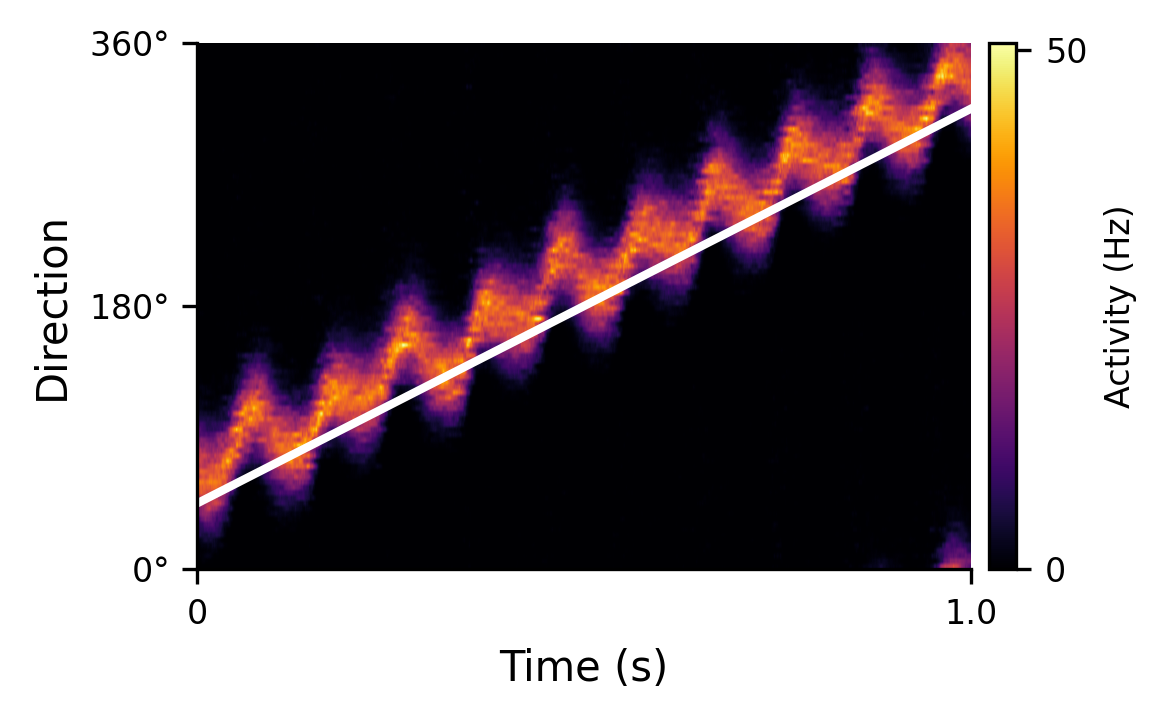

In [47]:
numT = 4000
time_steps = np.arange(numT)
#chaging head direction, mimicking the animal turning
Head_direction = 6*bm.pi*bm.arange(numT)/numT
#wrap to 0 to 2pi
Head_direction = bm.mod(Head_direction, 2*bm.pi) - bm.pi
bump_center, bump_activity = bm.for_loop(run_HDNet, (time_steps, Head_direction), progress_bar=True)
max_bump_activity = np.max(bump_activity, axis=1)

start = 1500
end = 2500+1
#polor

fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=300)
ax = plot_HDsweep(ax, 
                  time_steps[start:end], 
                  Head_direction[start:end], 
                  bump_center[start:end], 
                  max_bump_activity[start:end],
                    bump_activity[start:end])
plt.tight_layout()
plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/HD_sweep_rotating.pdf', dpi=300)